In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import calmap
import datetime
import tensorflow as tf
import os
import random
import re
import plotly.offline as pyoff
import plotly.graph_objs as go

from datetime import date
from plotly.subplots import make_subplots
from itertools import cycle, product
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from pmdarima.arima import ADFTest, auto_arima
from pmdarima.utils import diff_inv
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p, inv_boxcox1p
import matplotlib.patches as mpatches
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from IPython.core.display import HTML, display

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher" --iversions

Author: Herikc Brecher

calmap      : 0.0.9
pandas      : 1.2.2
matplotlib  : 3.4.2
seaborn     : 0.11.1
numpy       : 1.19.5
datetime    : 4.3
plotly      : 4.14.3
re          : 2.2.1
chart_studio: 1.1.0
tensorflow  : 2.5.0



In [3]:
# Variaveis globais
SEED = 84796315
FEATURES = 4
EPOCHS = 100
BATCH_SIZE = 1000
EXECUTE_GRID_SEARCH = False

In [4]:
# Configurando seeds
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Exibindo toda tela
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Preparando Conjunto de Pedidos

In [6]:
# Import dataset
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')

In [7]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAdjusted = dtOrders.copy()

In [8]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAdjusted[col] = pd.to_datetime(dtOrdersAdjusted[col], format = '%Y-%m-%d %H:%M:%S')

In [9]:
# Dropando valores NA
dtOrdersAdjusted = dtOrdersAdjusted.dropna()

In [10]:
dtOrdersAdjusted.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# 2. Iniciando Analise Seasonal

In [11]:
dtHistory = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

start = dtHistory.min()
end = dtHistory.max()

idx = pd.date_range(start, end, normalize=True)

seriesHistory = dtHistory.value_counts(sort=False).sort_index().reindex(idx, fill_value=0)

dtHistory = pd.DataFrame(seriesHistory).reset_index()

Principais outliers identificados:

- 1 de setembro de 2016 a 31 de dezembro de 2016: Dados quase inexistentes
- 24 de novembro de 2017: Pico de venda devido ao evento da blackfriday
- 17 de agosto de 2017 a 17 de outubro de 2017: Queda repentina nos dados

In [12]:
dtHistory

index  order_purchase_timestamp
0   2016-09-15                         1
1   2016-09-16                         0
2   2016-09-17                         0
3   2016-09-18                         0
4   2016-09-19                         0
..         ...                       ...
709 2018-08-25                        69
710 2018-08-26                        73
711 2018-08-27                        66
712 2018-08-28                        39
713 2018-08-29                        11

[714 rows x 2 columns]

In [13]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {"title": 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

In [14]:
# Remove outliers
seriesHistory = seriesHistory[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_range = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))
dtHistory = pd.DataFrame(seriesHistory).reset_index()

In [15]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {"title": 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

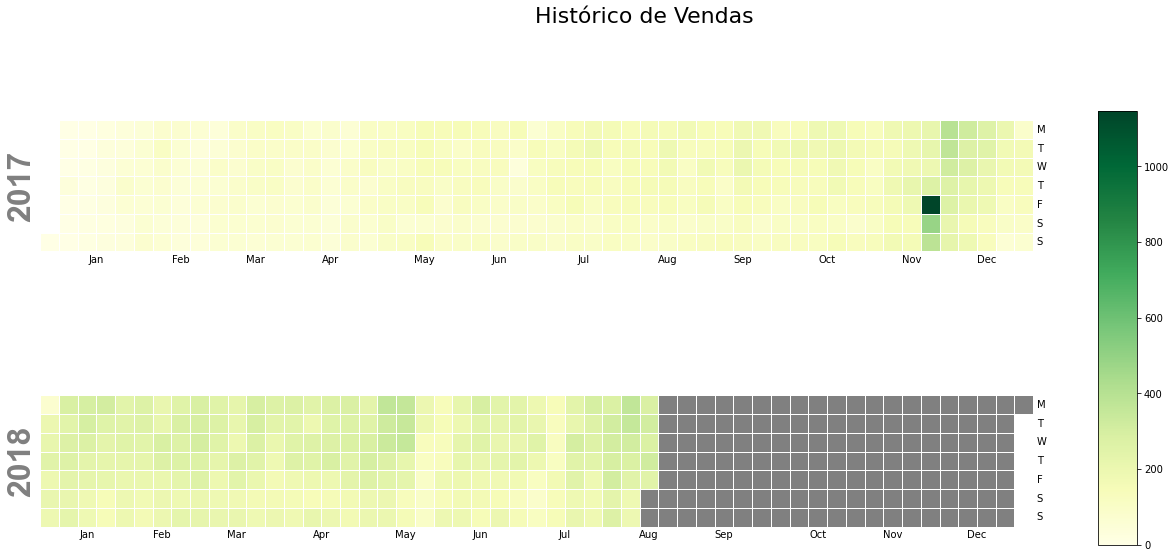

In [16]:
#Plot histórico de vendas por dia, mês e ano
fig, caxs = calmap.calendarplot(seriesHistory, daylabels='MTWTFSS', fillcolor='grey',cmap='YlGn', fig_kws=dict(figsize=(18, 9)))
fig.suptitle('Histórico de Vendas', fontsize=22)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax=cbar_ax)

plt.show()

In [17]:
# Criar grafico na estrutura STL 4 layers
def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    
    # Nome de cada um dos subplots
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            ax.legend(legend, frameon=False)

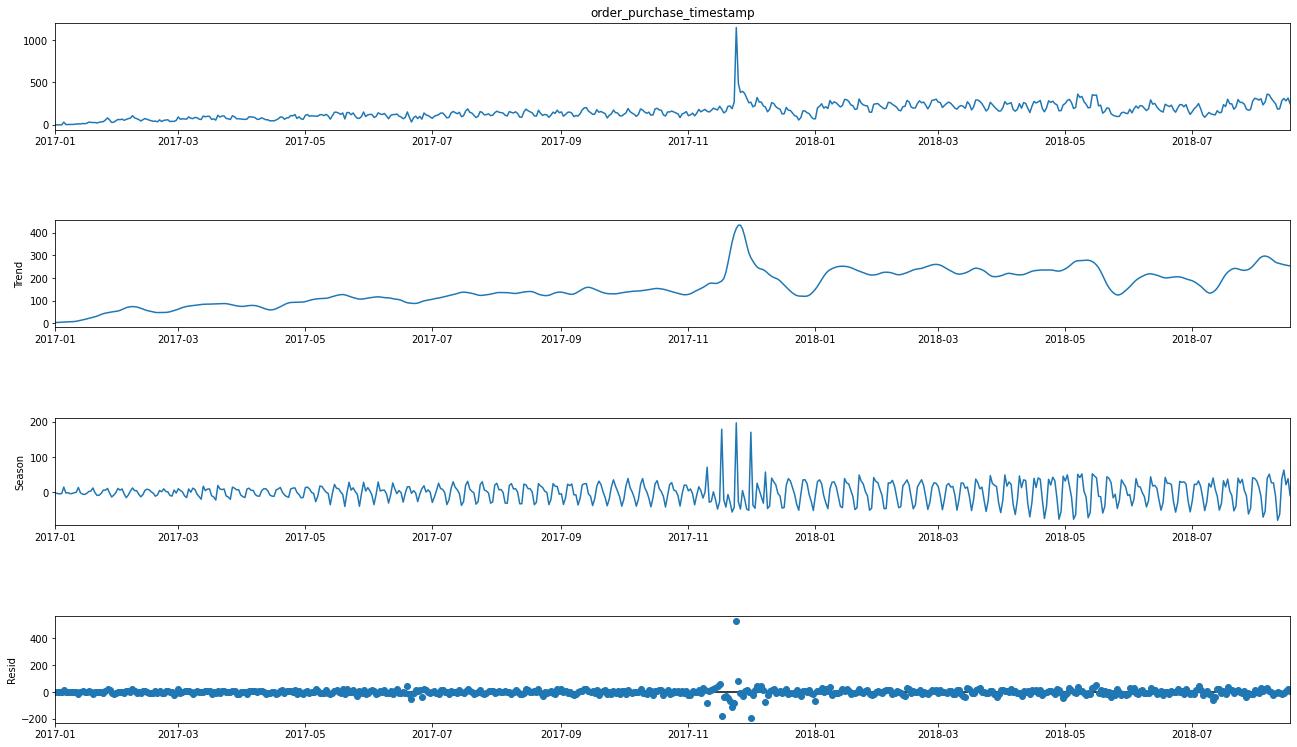

In [18]:
# Gerar STL
stl = STL(seriesHistory)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches((20, 12))
plt.show()

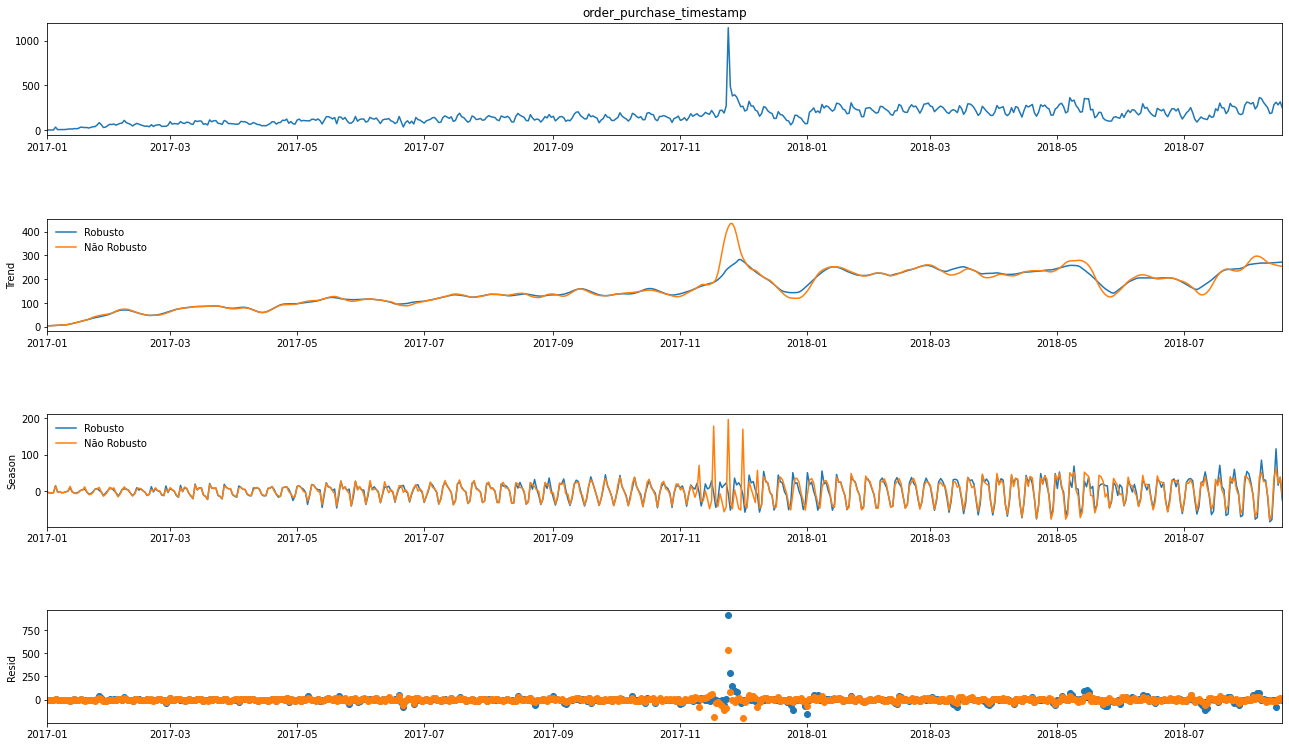

In [19]:
# Gerar STL não robusto e concatenar ao robusto
stl = STL(seriesHistory, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
fig.set_size_inches((20, 12))
res_non_robust = STL(seriesHistory, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robusto", "Não Robusto"])

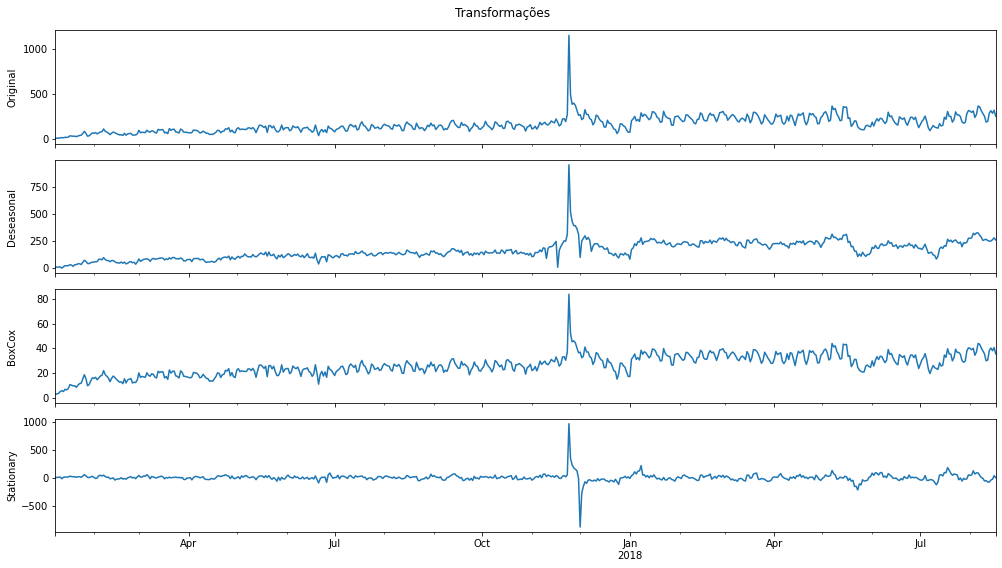

In [20]:
# Gerando STL para separar cada um dos componentes
stl = STL(seriesHistory)
res = stl.fit()

# Separando seriesDeseasonal
seriesDeseasonal = res.observed - res.seasonal

# Separando boxcox
seriesBoxCox, lmbda = boxcox(seriesHistory+1)
seriesBoxCox = pd.Series(seriesBoxCox, index=seriesHistory.index)

# Separando stationary
seriesDiffHistory = seriesHistory.diff(7).dropna()
xi = seriesHistory.iloc[:7]

# Plotando todos elementos de forma separada
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(14, 8))

seriesHistory.plot(ax=axs[0])
axs[0].set_ylabel('Original')

seriesDeseasonal.plot(ax=axs[1])
axs[1].set_ylabel('Deseasonal')

seriesBoxCox.plot(ax=axs[2])
axs[2].set_ylabel('BoxCox')

seriesDiffHistory.plot(ax=axs[3])
axs[3].set_ylabel('Stationary')

fig.align_ylabels()
fig.suptitle('Transformações')

plt.tight_layout()
plt.show()

## 2.1 Teste Estacionário ADF

Os testes abaixo concluiram:

O teste aceita a hipótese alternativa em que a série é estácionária.

ADF teste:

- Hipótese Nula(HO): A série possui unit root ou não é estacionária.
- Hipótese Alternativa(HA):  A série não possui unit root ou é estacionária.

In [21]:
# Teste ADF automatizado
def adf_test(series):
    result = adfuller(series, autolag='AIC')

    print(f'ADF: {result[0]}')
    print(f'steps: {result[1]}')
    print(f'p-value: {result[1]}')

    for key, value in result[4].items():
        print('\nValor Critico:')
        print(f'   {key}: {value}')    

In [22]:
adf = ADFTest(alpha = 0.05)
adf.should_diff(seriesHistory)

(0.01, False)

In [23]:
# Testando estacionaridade na série original
adf_test(seriesHistory)

ADF: -2.6163082378564684
steps: 0.08967331201291256
p-value: 0.08967331201291256

Valor Critico:
   1%: -3.441694608475642

Valor Critico:
   5%: -2.866544718556839

Valor Critico:
   10%: -2.5694353738653684


In [24]:
adf.should_diff(seriesDiffHistory)

(0.01, False)

In [25]:
adf_test(seriesDiffHistory)

ADF: -6.801606152090551
steps: 2.229745766641977e-09
p-value: 2.229745766641977e-09

Valor Critico:
   1%: -3.441834071558759

Valor Critico:
   5%: -2.8666061267054626

Valor Critico:
   10%: -2.569468095872659


# 3. Modelagem

Toda a etapa de modelagem será considerada com 5 passos a frente de previsão.

In [26]:
# Controle de resultados de toda fase de modelagem
result = pd.DataFrame(columns=['Algorithm', 'MSE', 'RMSE', 'MAE', 'Mean_Real_Value', 'Mean_Predict_Value'])

In [27]:
split_range = TimeSeriesSplit(n_splits = 8, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

In [28]:
# Adiciona o registro ao dataset
def record(result, algorithm, mse = -1, rmse = -1, mae = -1, mrv = -1, mpv = -1, show = True):
    new = pd.DataFrame(dict(Algorithm = algorithm, MSE = mse, RMSE = rmse, MAE = mae, Mean_Real_Value = mrv,\
                            Mean_Predict_Value = mpv), index=[0])
    result = pd.concat([result, new], ignore_index=True)
    
    if show:
        display(result)
    
    return result

In [29]:
# Plot no formato de 4 layers, seguindo o STL para cada um dos modelos
def plot(index, pred, mse, title, fig = None, ax = None, ylabel = ''):
    global seriesHistory
    
    empty_fig = fig is None
    
    if empty_fig:
        fig, ax = plt.subplots(figsize=(13, 6))
    else: 
        ax.set_ylabel(ylabel)
                
    ax.set_title(title)    
    patch_ = mpatches.Patch(color = 'white', label = f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles = [patch_], loc = 'upper left', fancybox = True, framealpha = 0.7,  handlelength = 0)
    ax.add_artist(L1)
    
    sns.lineplot(x = seriesHistory.index, y = seriesHistory, label = 'Real', ax = ax)
    sns.lineplot(x = index, y = pred, label = 'Previsto', ax = ax)
    ax.axvline(x = index[0], color = 'red')
    ax.legend(loc = 'upper right')
    
    if empty_fig:
        plt.show()
    else:
        return fig

In [30]:
# Calculo para previsão e teste quando utilizado a série Original
def calcPredTestOriginal(train, pred, test):
    return pred, test, 0

In [31]:
# Calculo para previsão e teste quando utilizado a série seriesDeseasonal
def calcPredTestseriesDeseasonal(train, pred, test):
    # Removendo a sazonalidade da série e convertendo para o shape correto
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count = pred.shape[0], dtype = float)
    test = test + res.seasonal.reindex_like(test)
    
    return pred, test, 1

In [32]:
# Calculo para previsão e teste quando utilizado a série BoxCox
def calcPredTestBoxCox(train, pred, test):
    # Reverdendo a normalização do boxcox
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    
    return pred, test, 2

In [33]:
# Calculo para previsão e teste quando utilizado a série Stationary
def calcPredTestStationary(train, pred, test):
    # Calculando a diferença da sazonalidade
    xi = seriesHistory.reindex_like(train).tail(FEATURES)
    
    totalLen = len(pred) + len(xi) 
    ix = pd.date_range(xi.index[0], periods = totalLen)  
    inv = diff_inv(pred, FEATURES, xi = xi) + np.fromiter(cycle(xi), count = totalLen, dtype = float)  
    inv = pd.Series(inv, index = ix, name = 'order_purchase_timestamp')
    pred = inv.iloc[FEATURES:]
    
    totalLen = len(test) + len(xi) 
    ix = pd.date_range(xi.index[0], periods = totalLen)  
    inv = diff_inv(test, FEATURES, xi = xi) + np.fromiter(cycle(xi), count = totalLen, dtype = float)  
    inv = pd.Series(inv, index = ix, name = 'order_purchase_timestamp')
    test = inv.iloc[FEATURES:]
    
    return pred, test, 3

## 3.1 TSR (Time Series Regression)

In [34]:
# Report para Time Series Regressor, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportTSR(data, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Time Series Regression'
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        gen = TimeseriesGenerator(train, train, FEATURES, batch_size = BATCH_SIZE)

        X_train = gen[0][0]
        y_train = gen[0][1]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        X_pred = y_train[-FEATURES:].reshape(1,-1)
        pred = np.empty(test.shape[0])

        for i in range(len(pred)):
            forecast = lr.predict(X_pred)
            X_pred = np.delete(X_pred, 0, 1)
            X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
            pred[i] = forecast
        
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [35]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.tight_layout()
plt.close()

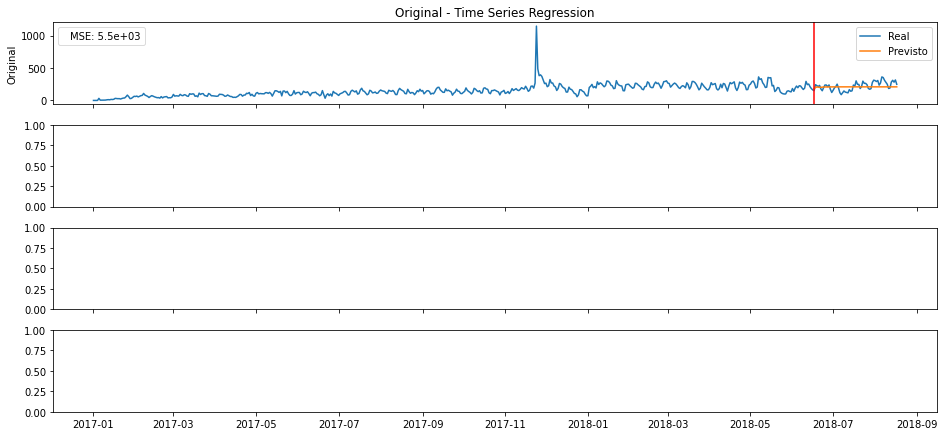

In [36]:
reportTSR(seriesHistory.copy(), 'Original', calcPredTestOriginal)

## 3.2 STL seriesDeseasonal - TSR (Time Series Regression)

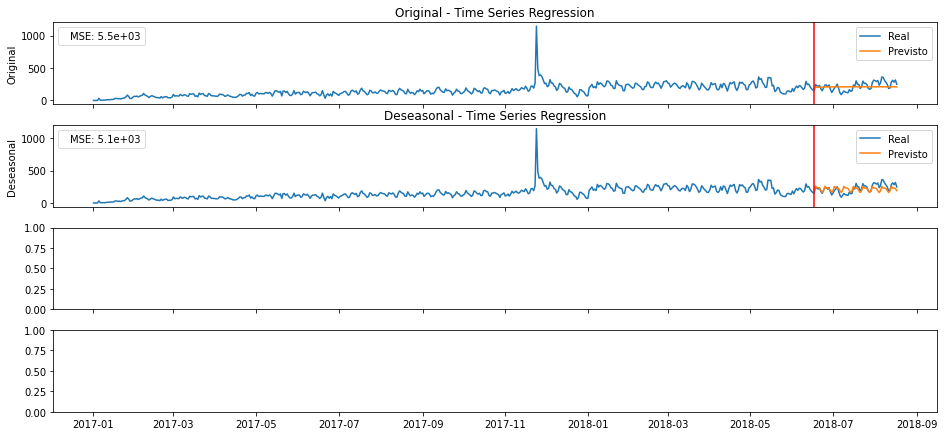

In [37]:
reportTSR(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.3 BoxCox - TSR (Time Series Regression)

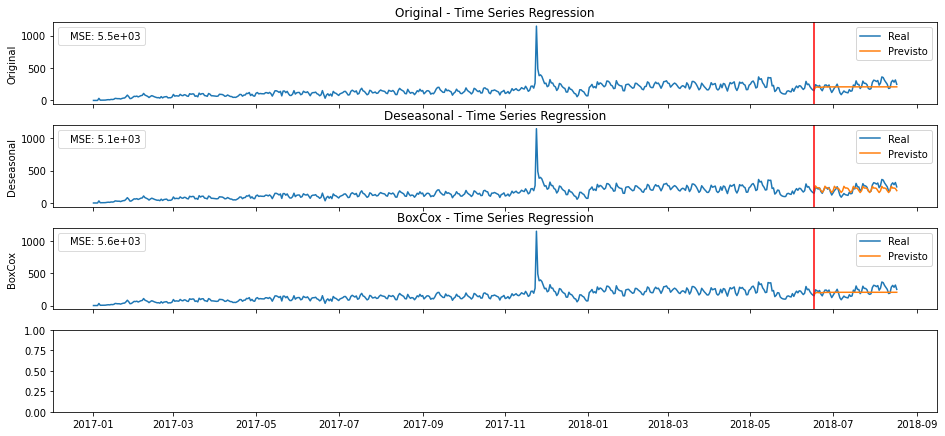

In [38]:
reportTSR(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox)

## 3.4 Stationary - TSR (Time Series Regression)

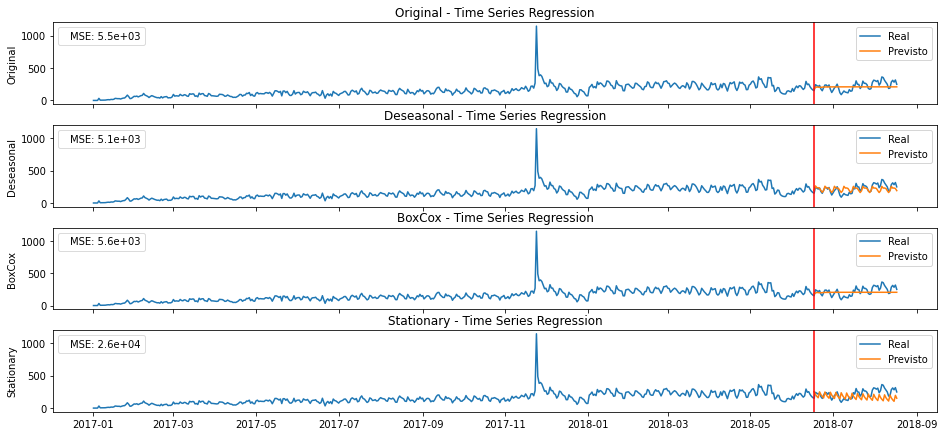

In [39]:
reportTSR(seriesDiffHistory.copy(), 'Stationary', calcPredTestStationary)

In [40]:
result

Algorithm           MSE        RMSE        MAE  \
0    Original - Time Series Regression   5535.832848   63.623562  45.478472   
1  Deseasonal - Time Series Regression   5093.004952   58.412295  40.037188   
2      BoxCox - Time Series Regression   5596.674780   64.178103  46.040926   
3  Stationary - Time Series Regression  26384.123936  133.283693  97.039716   

   Mean_Real_Value  Mean_Predict_Value  
0       179.560484          162.890741  
1       179.560484          165.116295  
2       179.560484          159.936426  
3       183.760081          172.851289

## 3.5 Exponential Smoothing

In [41]:
# Função utilizada para o hypertuning de alpha, beta e gamma do Exponential Smoothing
def GSES(data, modelName, alpha, beta, gamma, calcFunction):    
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                ES = (
                    ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=FEATURES)
                    .fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma, method='ls')
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))
        
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [42]:
# Função utilizada para o hypertuning de demais parâmetros do Exponential Smoothing
def GSESOPT(data, modelName, trend, season, periods, bias, method, calcFunction):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                ES = (
                    ExponentialSmoothing(train, trend = trend, seasonal = season, seasonal_periods = periods)
                    .fit(remove_bias = bias, method = method, optimized = True)
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))       
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [43]:
# Report para Exponential Smoothing, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportES(data, modelName, model_kwargs, fit_kwargs, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Exponential Smoothing'
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        ES = ExponentialSmoothing       
        stlf = STLForecast(train, ES, model_kwargs = model_kwargs).fit(fit_kwargs = fit_kwargs)
        pred = stlf.forecast(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [44]:
# Função para gerar tabela de hypertuning ampla
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # Lista de argumentos
    t_params = ['add', 'mul', None]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    r_params = [True, False]
    method_params = ['L-BFGS-B' , 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'bh', 'ls']
    
    # Gerando lista de argumentos
    for t in t_params:
        for s in s_params:
            for p in p_params:
                for r in r_params:
                    for m in method_params:
                        cfg = [t, s, p, r, m]
                        models.append(cfg)
    return models

In [45]:
# Gerando tabela de hypertunning
alphas = betas = gammas = np.arange(1, step=0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
hyperparam.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [46]:
%%time

# Treinamento do modelo 
if EXECUTE_GRID_SEARCH:  
    hyperparam['mse'] = hyperparam.apply(lambda x: GSES(seriesHistory.copy(), 'Original',\
                                                x.alpha, x.beta, x.gamma, calcPredTestOriginal), axis = 1)

Wall time: 0 ns


In [47]:
# Verificando o menor mse
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [48]:
# Criando lista de argumentos ampla
params_ = exp_smoothing_configs([FEATURES])

In [49]:
hyperparam_ = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [50]:
len(hyperparam_)

126

In [51]:
hyperparam_.head()

trend season  periods  bias        method
0   add    add        4  True      L-BFGS-B
1   add    add        4  True           TNC
2   add    add        4  True         SLSQP
3   add    add        4  True        Powell
4   add    add        4  True  trust-constr

In [52]:
%%time

# Se True irá treinar com a nova lista mais ampla (pode demorar)
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.apply(lambda x: GSESOPT(seriesHistory.copy(), 'Original',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestOriginal),\
                                   axis = 1)

Wall time: 0 ns


In [53]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [54]:
# Reset da figura
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

In [55]:
# Dicionar de configurações de acordo com o hypertuning
model_kwargs = dict(trend = None, seasonal = None, seasonal_periods = FEATURES)
fit_kwargs = dict(remove_bias = False, smoothing_level = 0.1, smoothing_trend = 0.1, smoothing_seasonal = 0.4,\
                  method = 'Powell')

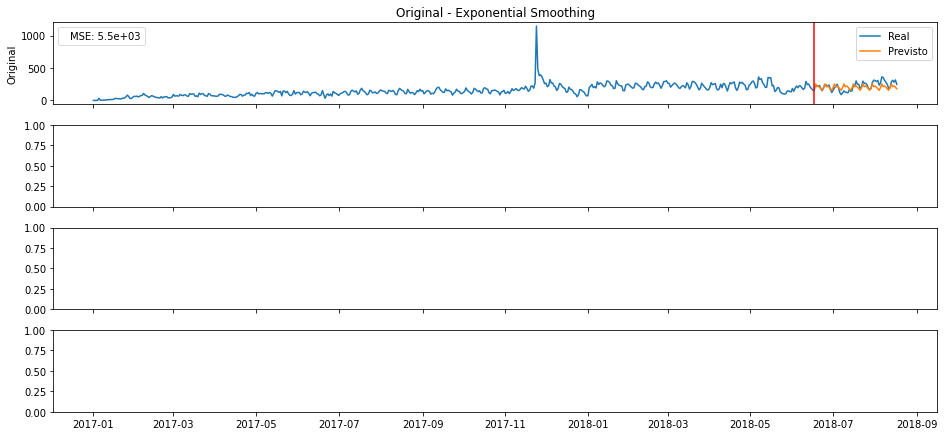

In [56]:
reportES(seriesHistory.copy(), 'Original', model_kwargs, fit_kwargs, calcPredTestOriginal)

## 3.6 seriesDeseasonal - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesHistory para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [57]:
alphas = betas = gammas = np.arange(1, step=0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
hyperparam.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [58]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSES(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                x.alpha, x.beta, x.gamma, calcPredTestseriesDeseasonal), axis=1)

Wall time: 0 ns


In [59]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [60]:
params_ = exp_smoothing_configs([FEATURES])

In [61]:
hyperparam_ = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [62]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.apply(lambda x: GSESOPT(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestseriesDeseasonal),\
                                   axis = 1)

Wall time: 0 ns


In [63]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [64]:
model_kwargs = dict(trend = None, seasonal = 'add', seasonal_periods = FEATURES)
fit_kwargs = dict(remove_bias = True, smoothing_level = 0.1, smoothing_trend = 0.1, smoothing_seasonal = 0.7, method = 'Powell')

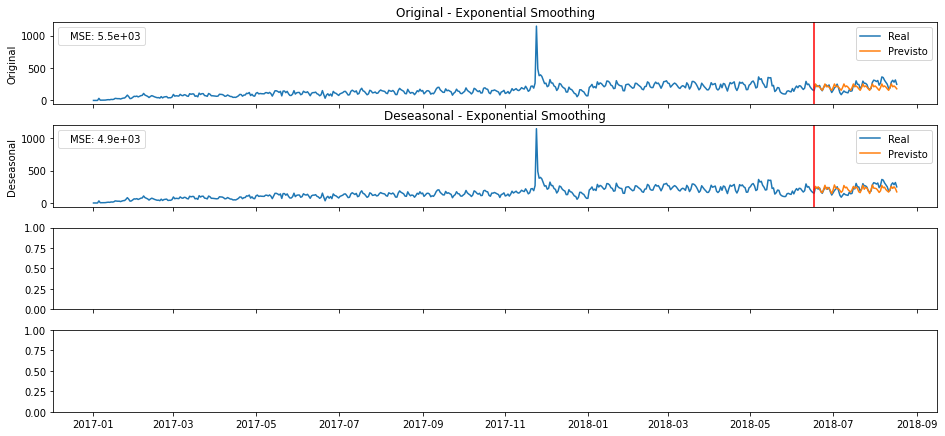

In [65]:
reportES(seriesDeseasonal.copy(), 'Deseasonal', model_kwargs, fit_kwargs, calcPredTestseriesDeseasonal)

## 3.7 BoxCox - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesHistory para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [66]:
alphas = betas = gammas = np.arange(1, step=0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
hyperparam.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [67]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSES(seriesBoxCox.copy(), 'BoxCox',\
                                                x.alpha, x.beta, x.gamma, calcPredTestBoxCox), axis=1)

Wall time: 0 ns


In [68]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [69]:
params_ = exp_smoothing_configs([FEATURES])

In [70]:
hyperparam_ = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [71]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.apply(lambda x: GSESOPT(seriesBoxCox.copy(), 'BoxCox',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestBoxCox),\
                                   axis = 1)

Wall time: 0 ns


In [72]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [75]:
model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=FEATURES)
fit_kwargs = dict(remove_bias = True, smoothing_level = 0.1, smoothing_trend = 0.1, smoothing_seasonal = 0.4,\
                  method = 'Powell')

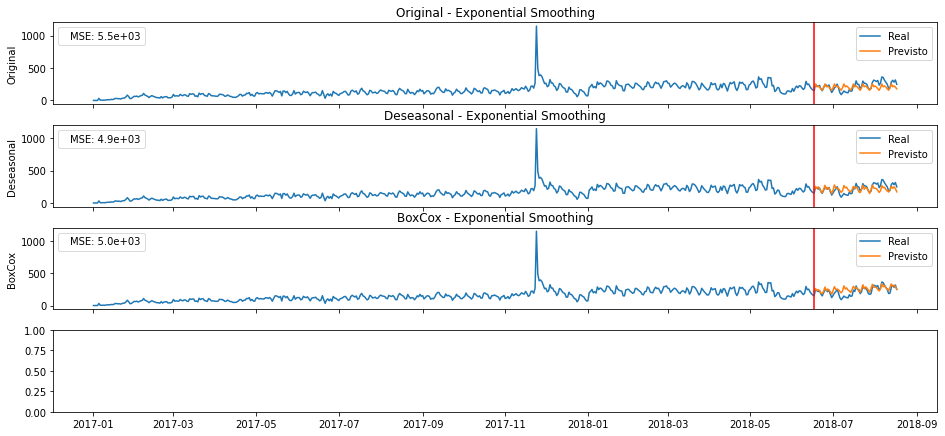

In [76]:
reportES(seriesBoxCox.copy(), 'BoxCox', model_kwargs, fit_kwargs, calcPredTestBoxCox)

## 3.8 Seasonal - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesHistory para seriesDiffHistory, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [77]:
alphas = betas = gammas = np.arange(1, step=0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
hyperparam.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [78]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSES(seriesDiffHistory.copy(), 'Stationary',\
                                                x.alpha, x.beta, x.gamma, calcPredTestStationary), axis=1)

Wall time: 0 ns


In [79]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [80]:
params_ = exp_smoothing_configs([FEATURES])

In [81]:
hyperparam_ = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [82]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.apply(lambda x: GSESOPT(seriesDiffHistory.copy(), 'Stationary',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestStationary),\
                                   axis = 1)

Wall time: 0 ns


In [83]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [84]:
model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=FEATURES)
fit_kwargs = dict(remove_bias = False, smoothing_level = 0, smoothing_trend = 0, smoothing_seasonal = 0,\
                  method = 'ls')

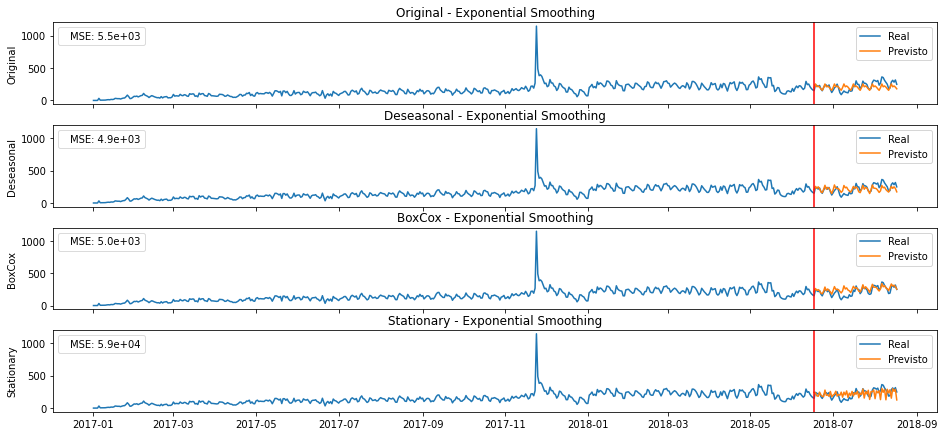

In [85]:
reportES(seriesDiffHistory.copy(), 'Stationary', model_kwargs, fit_kwargs, calcPredTestStationary)

In [86]:
result

Algorithm           MSE        RMSE         MAE  \
0    Original - Time Series Regression   5535.832848   63.623562   45.478472   
1  Deseasonal - Time Series Regression   5093.004952   58.412295   40.037188   
2      BoxCox - Time Series Regression   5596.674780   64.178103   46.040926   
3  Stationary - Time Series Regression  26384.123936  133.283693   97.039716   
4     Original - Exponential Smoothing   5523.286110   60.505490   41.256041   
5   Deseasonal - Exponential Smoothing   4866.086916   56.458883   38.015761   
6       BoxCox - Exponential Smoothing   4950.037569   58.438083   39.977467   
7   Stationary - Exponential Smoothing  59026.433008  209.919105  150.638046   

   Mean_Real_Value  Mean_Predict_Value  
0       179.560484          162.890741  
1       179.560484          165.116295  
2       179.560484          159.936426  
3       183.760081          172.851289  
4       179.560484          170.716575  
5       179.560484          169.031030  
6       179.560484          175.454550  
7       183.760081          174.927305

## 3.9 ARIMA

In [87]:
# Report do algoritmo arima, também é adicionado a base de resultados e realizado o plot de acompanhamento
def reportArima(arimaModel, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - '  + arimaModel.__str__().strip()
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        arimaModel.fit(train)
        pred = arimaModel.predict(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [88]:
# Reset da figura
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

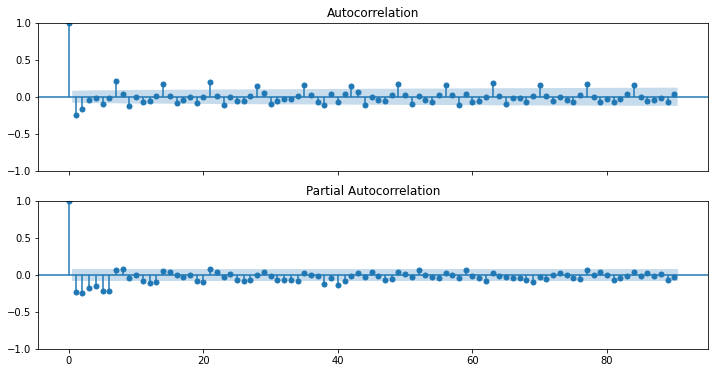

In [89]:
# Correlação entre os periodos com ARIMA

lags = 90

with catch_warnings():
    filterwarnings("ignore")
    fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
    plot_acf(seriesHistory.diff().dropna(), ax = ax[0], lags = lags, missing = 'drop')
    plot_pacf(seriesHistory.diff().dropna(), ax = ax[1], lags = lags)
    plt.show()

In [90]:
%%time

# Utilizando o auto arima para descobrir os argumentos ideias baseados no conjunto de dado informado
data = seriesHistory.copy()
arimaModel = auto_arima(seriesHistory.copy(), m = FEATURES)
arimaModel

Wall time: 8.06 s


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True, with_intercept=False)

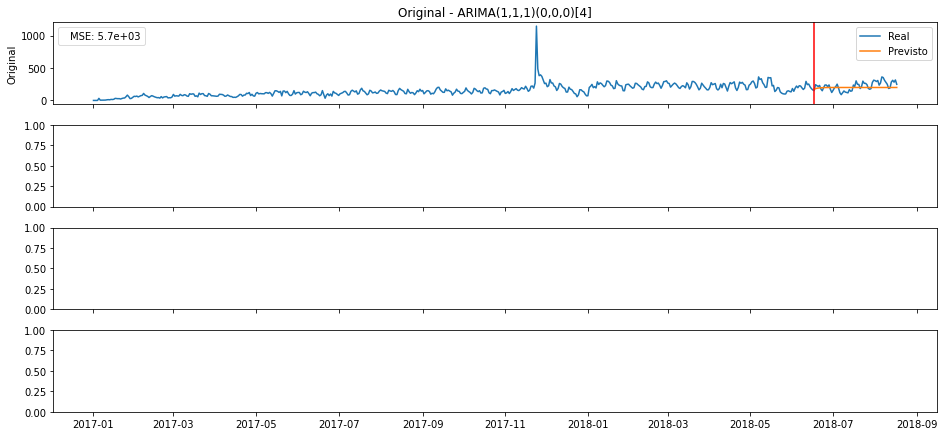

In [91]:
reportArima(arimaModel, 'Original', calcPredTestOriginal)

## 3.10 seriesDeseasonal - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesHistory para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [92]:
%%time
data = seriesDeseasonal.copy()
arimaModel = auto_arima(data, seasonal = False)
arimaModel

Wall time: 2.58 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

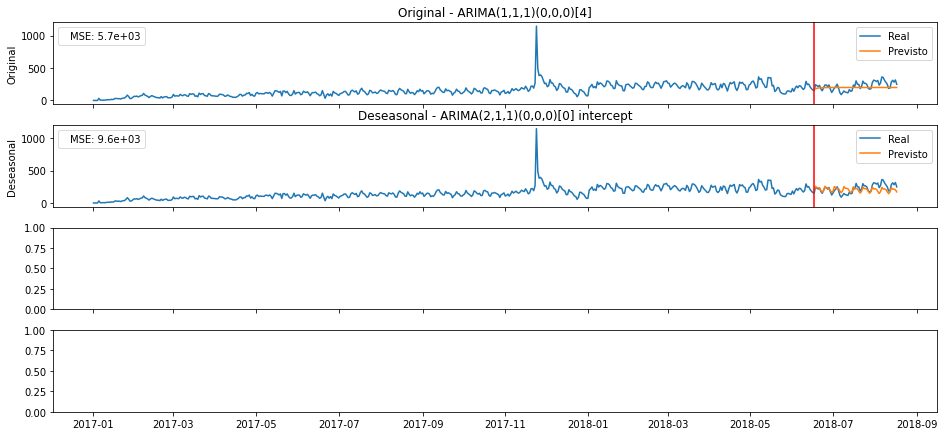

In [93]:
reportArima(arimaModel, 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.11 BoxCox - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesHistory para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [94]:
%%time
data = seriesBoxCox.copy()
arimaModel = auto_arima(data, m = FEATURES)
arimaModel

Wall time: 7.67 s


ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True, with_intercept=False)

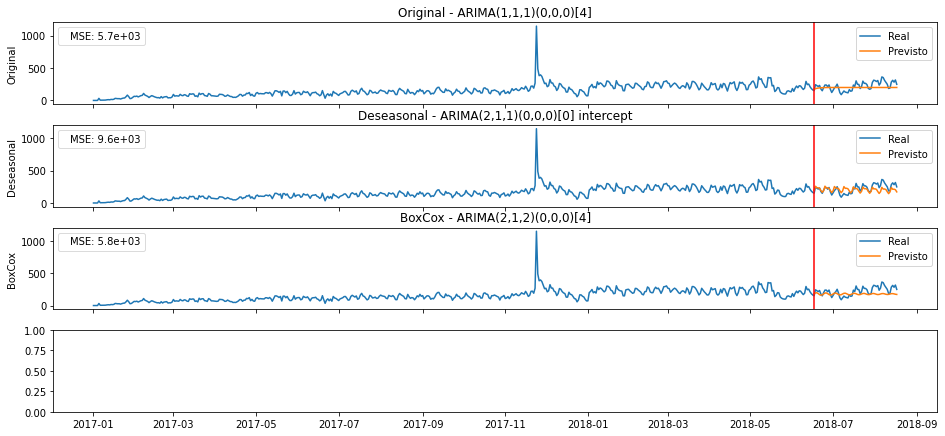

In [95]:
reportArima(arimaModel, 'BoxCox', calcPredTestBoxCox)

## 3.12 Stationary - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [96]:
%%time
data = seriesDiffHistory.copy()
arimaModel = auto_arima(data, seasonal = False)
arimaModel

Wall time: 11.8 s


ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True)

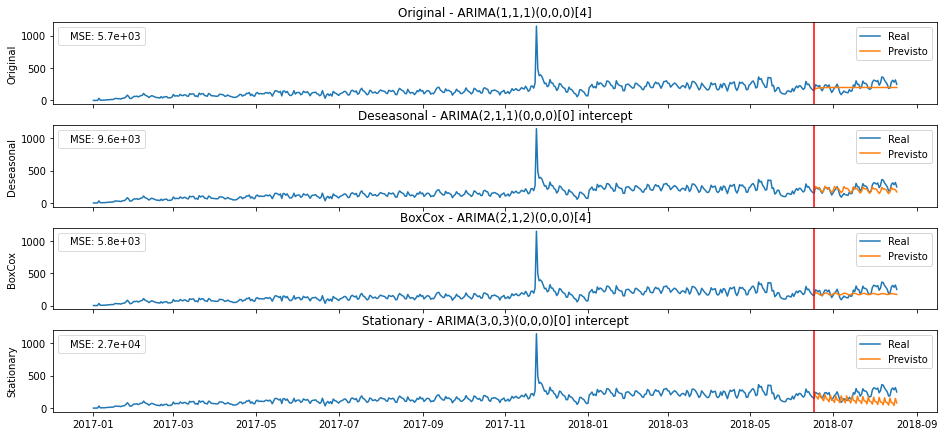

In [97]:
reportArima(arimaModel, 'Stationary', calcPredTestStationary)

In [98]:
result

Algorithm           MSE        RMSE  \
0               Original - Time Series Regression   5535.832848   63.623562   
1             Deseasonal - Time Series Regression   5093.004952   58.412295   
2                 BoxCox - Time Series Regression   5596.674780   64.178103   
3             Stationary - Time Series Regression  26384.123936  133.283693   
4                Original - Exponential Smoothing   5523.286110   60.505490   
5              Deseasonal - Exponential Smoothing   4866.086916   56.458883   
6                  BoxCox - Exponential Smoothing   4950.037569   58.438083   
7              Stationary - Exponential Smoothing  59026.433008  209.919105   
8               Original - ARIMA(1,1,1)(0,0,0)[4]   5707.329393   63.881702   
9   Deseasonal - ARIMA(2,1,1)(0,0,0)[0] intercept   9591.508344   77.052176   
10                BoxCox - ARIMA(2,1,2)(0,0,0)[4]   5804.008390   64.822873   
11  Stationary - ARIMA(3,0,3)(0,0,0)[0] intercept  27308.769495  135.413963   

           MAE  Mean_Real_Value  Mean_Predict_Value  
0    45.478472       179.560484          162.890741  
1    40.037188       179.560484          165.116295  
2    46.040926       179.560484          159.936426  
3    97.039716       183.760081          172.851289  
4    41.256041       179.560484          170.716575  
5    38.015761       179.560484          169.031030  
6    39.977467       179.560484          175.454550  
7   150.638046       183.760081          174.927305  
8    45.981605       179.560484          169.582968  
9    59.641647       179.560484          191.565756  
10   46.304752       179.560484          162.385317  
11   97.730612       183.760081          157.363007

## 3.13 LSTM

In [99]:
# Redefinindo variaveis globais para o treino utilizando LSTM

BATCH_SIZE = 30

In [100]:
# hypertuning do algoritmo de LSTM
def GSLSTM(data, learning_rate, calcFunction):
    mse = []
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        try:
            with catch_warnings():
                filterwarnings("ignore")
                
                # Normalização e reshape do conjunto de treino
                ss = StandardScaler()
                ss.fit(train.values.reshape(-1, 1))
                train_input = ss.transform(train.values.reshape(-1, 1))
                
                # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
                test_input = train_input[-(FEATURES + 1):]
                test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reset da sessão
                clear_session()
                
                # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
                initializer = GlorotUniform(seed = SEED)
                model = Sequential()
                
                # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
                model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
                model.add(Dense(1, kernel_initializer = initializer))
                model.add(BatchNormalization())
                model.add(Dense(1, kernel_initializer = initializer))
                
                # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
                early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
                
                # Treinando o modelo com otimizador Adam
                model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
                h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
                pred = np.empty(test.shape[0])
                
                # Realizando predições no conjunto de teste
                for i in range(len(pred)):
                    prediction = model.predict(test_gen, verbose = False)
                    pred[i] = prediction
                    test_input = np.delete(test_input, 0, 0)
                    test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
                    test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reorganizando o shape e chamando a função de calculo
                pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
                pred, test, _ = calcFunction(train, pred, test)      

                mse.append(mean_squared_error(pred, test))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [101]:
# Report do algoritmo LSTM
def reportLSTM(data, modelName, calcFunction, learning_rate):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Long Short Term Memory (LSTM)'
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        # Normalização e reshape do conjunto de treino
        ss = StandardScaler()
        ss.fit(train.values.reshape(-1, 1))
        train_input = ss.transform(train.values.reshape(-1, 1))

        # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
        test_input = train_input[-(FEATURES + 1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
        train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reset da sessão
        clear_session()
        
        # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
        initializer = GlorotUniform(seed = SEED)
        model = Sequential()
        
        # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
        model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
        model.add(Dense(1, kernel_initializer = initializer))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer = initializer))
        
        # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
        early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
        
        # Treinando o modelo com otimizador Adam
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
        h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
        pred = np.empty(test.shape[0])

        # Realizando predições no conjunto de teste
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose = False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
            test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reorganizando o shape e chamando a função de calculo
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [102]:
# Gerando tabela de hypertunning com taxas de learning_rate
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns=['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [103]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSLSTM(seriesHistory.copy(), x.learning_rate, calcPredTestOriginal), axis=1)

Wall time: 0 ns


In [104]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [105]:
# Reset da figura
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

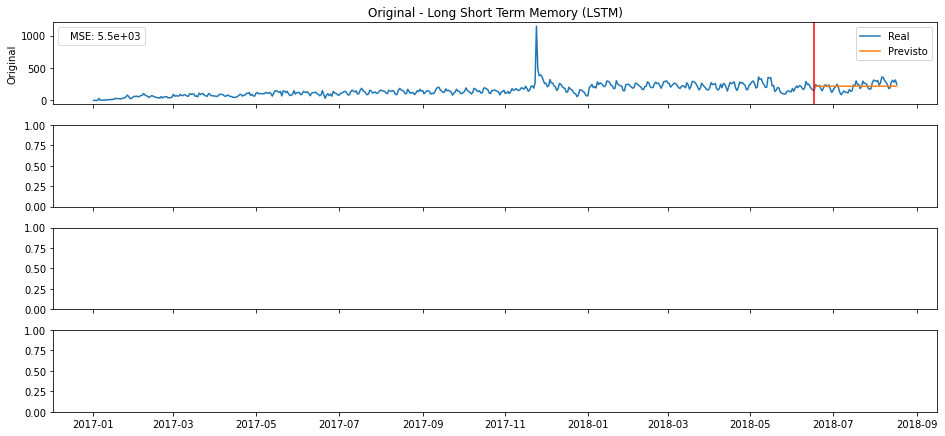

In [106]:
reportLSTM(seriesHistory.copy(), 'Original', calcPredTestOriginal, 0.001)

## 3.14 seriesDeseasonal - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [107]:
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [108]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSLSTM(seriesDeseasonal.copy(), x.learning_rate, calcPredTestseriesDeseasonal), axis = 1)

Wall time: 0 ns


In [109]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

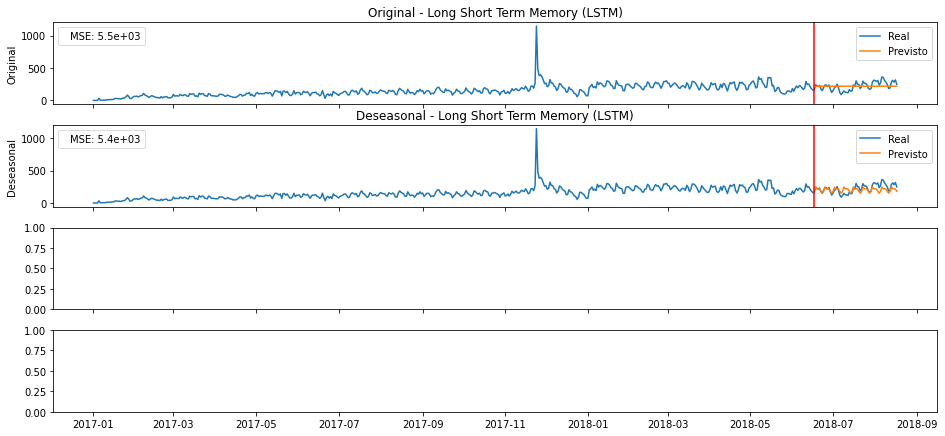

In [110]:
reportLSTM(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal, 0.01)

## 3.15 BoxCox - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [111]:
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns=['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [112]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSLSTM(seriesBoxCox.copy(), x.learning_rate, calcPredTestBoxCox), axis=1)

Wall time: 0 ns


In [113]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

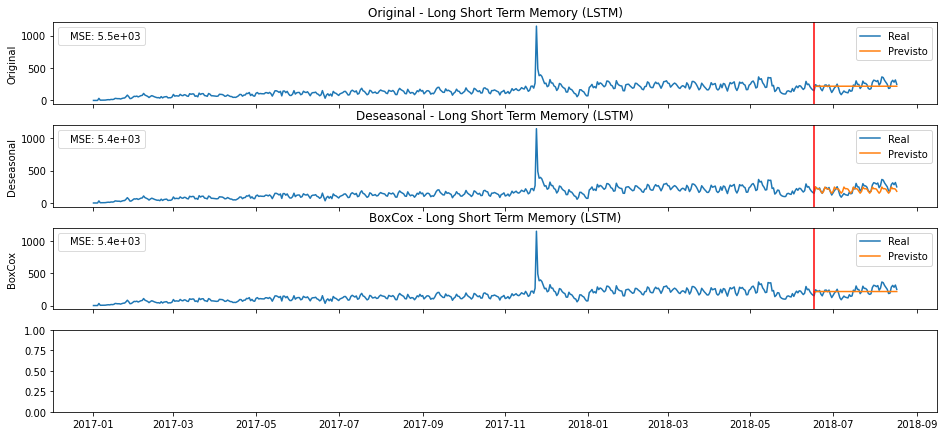

In [114]:
reportLSTM(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox, 0.01)

## 3.16 Stationary - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [115]:
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns=['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [116]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.apply(lambda x: GSLSTM(seriesDiffHistory.copy(), x.learning_rate, calcPredTestStationary), axis=1)

Wall time: 0 ns


In [117]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

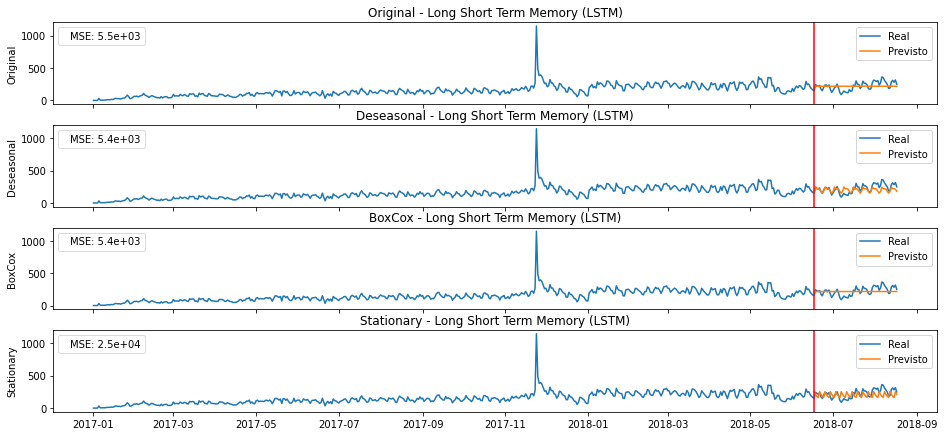

In [118]:
reportLSTM(seriesDiffHistory.copy(), 'Stationary', calcPredTestStationary, 0.0001)

In [119]:
result

Algorithm           MSE        RMSE  \
0               Original - Time Series Regression   5535.832848   63.623562   
1             Deseasonal - Time Series Regression   5093.004952   58.412295   
2                 BoxCox - Time Series Regression   5596.674780   64.178103   
3             Stationary - Time Series Regression  26384.123936  133.283693   
4                Original - Exponential Smoothing   5523.286110   60.505490   
5              Deseasonal - Exponential Smoothing   4866.086916   56.458883   
6                  BoxCox - Exponential Smoothing   4950.037569   58.438083   
7              Stationary - Exponential Smoothing  59026.433008  209.919105   
8               Original - ARIMA(1,1,1)(0,0,0)[4]   5707.329393   63.881702   
9   Deseasonal - ARIMA(2,1,1)(0,0,0)[0] intercept   9591.508344   77.052176   
10                BoxCox - ARIMA(2,1,2)(0,0,0)[4]   5804.008390   64.822873   
11  Stationary - ARIMA(3,0,3)(0,0,0)[0] intercept  27308.769495  135.413963   
12       Original - Long Short Term Memory (LSTM)   5520.747615   63.657881   
13     Deseasonal - Long Short Term Memory (LSTM)   5438.694711   62.358559   
14         BoxCox - Long Short Term Memory (LSTM)   5435.066192   62.369496   
15     Stationary - Long Short Term Memory (LSTM)  24896.840655  125.707624   

           MAE  Mean_Real_Value  Mean_Predict_Value  
0    45.478472       179.560484          162.890741  
1    40.037188       179.560484          165.116295  
2    46.040926       179.560484          159.936426  
3    97.039716       183.760081          172.851289  
4    41.256041       179.560484          170.716575  
5    38.015761       179.560484          169.031030  
6    39.977467       179.560484          175.454550  
7   150.638046       183.760081          174.927305  
8    45.981605       179.560484          169.582968  
9    59.641647       179.560484          191.565756  
10   46.304752       179.560484          162.385317  
11   97.730612       183.760081          157.363007  
12   45.726862       179.560484          161.388863  
13   43.289021       179.560484          161.158756  
14   44.616543       179.560484          160.700862  
15   91.236448       183.760081          180.286755

## 4. Comparação

In [120]:
# Tratando nomes e criando colunas de controle para os resultados gerados
topResult = (
    result 
    .assign(Full_Name = lambda x: x.Algorithm.apply(lambda a: a.split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .assign(Data_Category = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[0]))
    .assign(Algorithm = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[1].split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .sort_values('MSE')
)

In [121]:
topResult.head()

Algorithm          MSE       RMSE        MAE  \
5    Exponential Smoothing  4866.086916  56.458883  38.015761   
6    Exponential Smoothing  4950.037569  58.438083  39.977467   
1   Time Series Regression  5093.004952  58.412295  40.037188   
14                   LSTM   5435.066192  62.369496  44.616543   
13                   LSTM   5438.694711  62.358559  43.289021   

    Mean_Real_Value  Mean_Predict_Value                            Full_Name  \
5        179.560484          169.031030   Deseasonal - Exponential Smoothing   
6        179.560484          175.454550       BoxCox - Exponential Smoothing   
1        179.560484          165.116295  Deseasonal - Time Series Regression   
14       179.560484          160.700862                       BoxCox - LSTM    
13       179.560484          161.158756                   Deseasonal - LSTM    

   Data_Category  
5     Deseasonal  
6         BoxCox  
1     Deseasonal  
14        BoxCox  
13    Deseasonal

In [122]:
# Plot dos resultados obtidos por ordem ascendente do MSE

colors = {'Time Series Regression':'red',
          'Exponential Smoothing':'orange',
          'Auto Arima': 'green',
          'LSTM ': 'blue'}

# plotly figure
fig = go.Figure(layout = go.Layout(yaxis = {"type": "category", 'title': 'Algoritmo e Categoria'},
                        xaxis = {'title': 'MSE'},
                        title = 'MSE por Algoritmo e Tipo de Dado'))

for t in topResult['Algorithm'].unique():
    topResultFiltered = topResult[topResult['Algorithm']==t].copy()
    fig.add_traces(go.Bar(x = topResultFiltered['MSE'], y = topResultFiltered['Full_Name'], name = str(t),\
                          marker_color = str(colors[t]), orientation = 'h',
                          text = round(topResultFiltered['MSE']), textposition = 'outside'))
    
    
fig.update_layout(yaxis={'categoryorder':'total descending'}, autosize = False,
                  width = 1450,
                  height = 800)    
    
fig.show()